# Fit Continuous Distributions

Required File Inputs:
1. `BCUB_watershed_attributes_updated.csv`
2. `data_processing_functions.py`
3. `BCUB_watershed_attributes_updated.geojson`
4. `hysets_series.zip`

**Note**: At the top of `data_processing_functions.py` you need to specify the path to the HYSETS streamflow files:

`STREAMFLOW_DIR = '/path_to/hysets_series/`

Unpacking the `hysets_series.zip` archive will yield a folder with the individual `.csv` files named `<station_id>.csv`, i.e.:

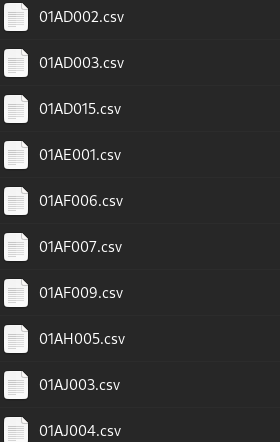

Just update `STREAMFLOW_DIR` to wherever you saved it.


## Method

For each streamflow timeseries:

1. Compute "sufficient statistics" of a chosen distribution, i.e. location and scale of log-normal distribution.
2. Use the parameters as a model Q in pairwise comparisons, these eliminate 

In [ ]:
import os
from time import time
from scipy.stats import entropy
import multiprocessing as mp
import data_processing_functions as dpf
import numpy as np
import pandas as pd
import geopandas as gpd

# visualize the catchment centroid locations
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.palettes import Colorblind, Sunset10
output_notebook()

from scipy.stats import lognorm, expon
from scipy.special import kl_div

BASE_DIR = os.getcwd()

In [ ]:
# create a new output filename 
attributes_filename = 'BCUB_watershed_attributes_updated.csv'
attributes_fpath = os.path.join(os.getcwd(), 'data', attributes_filename)
attr_df = pd.read_csv(attributes_fpath)
attr_df.columns = [e.lower() for e in attr_df.columns]
# df.columns
filtered_stns = sorted(list(set(attr_df['official_id'].values)))

In [ ]:
def generate_and_plot_lognormal(mu1, sigma1, mu2, sigma2, b, prior_pseudo_count, y_range=(0, 0.035)):
    """
    Generates two log-normal distributions, quantizes them with 2^b symbols,
    applies a uniform pseudo-count prior to one, and plots the distributions
    with Bokeh (including the posterior as a dashed line).

    Parameters:
    - mu1, sigma1: Parameters for the first log-normal distribution.
    - mu2, sigma2: Parameters for the second log-normal distribution.
    - b: Number of symbols = 2^b for quantization.
    - prior_pseudo_count: Uniform pseudo-count to apply to one distribution.
    """
    # Create the two log-normal distributions
    minx, maxx = 0.0, 5
    x = np.linspace(minx, maxx, 200)  # Values over which distributions are evaluated
    dist1 = lognorm.pdf(x, sigma1, loc=mu1, scale=sigma1)
    dist2 = lognorm.pdf(x, sigma2, loc=mu2, scale=sigma2)

    bins = np.linspace(minx, maxx, 2 ** b + 1)
    bins_midpoints = (bins[:-1] + bins[1:]) / 2

    # Create the continuous log-normal distributions evaluated at the midpoints
    dist1 = lognorm.pdf(bins_midpoints, sigma1, scale=np.exp(mu1))
    dist2 = lognorm.pdf(bins_midpoints, sigma2, scale=np.exp(mu2))

    dist3 = lognorm.pdf(bins_midpoints, sigma1, scale=np.exp(mu1))
    dist4 = lognorm.pdf(bins_midpoints, sigma2, scale=np.exp(mu2))

    # Quantize the distributions
    # Normalize the distributions to form proper PDFs over the quantized bins
    P = dist1 / np.sum(dist1)
    Q = dist2 / np.sum(dist2)

    # Apply the uniform prior as pseudo-counts to the second distribution
    prior_counts = np.full_like(Q, prior_pseudo_count)
    posterior_counts = prior_counts + Q * np.sum(dist2)  # Bayesian update
    R = posterior_counts / np.sum(posterior_counts)  # Renormalize

    assert np.abs(sum(P) - 1) < 0.001, 'P does not sum to 1'
    assert np.abs(sum(Q) - 1) < 0.001, 'Q does not sum to 1'
    assert np.abs(sum(R) - 1) < 0.001, 'R does not sum to 1'

    kl_pq = kl_div(P, Q)
    kl_pr = kl_div(P, R)

    # Prepare data for Bokeh plotting
    source1 = ColumnDataSource(data=dict(x=bins_midpoints, y=P))
    source2 = ColumnDataSource(data=dict(x=bins_midpoints, y=Q))
    source2_posterior = ColumnDataSource(data=dict(x=bins_midpoints, y=R))

    # Create the Bokeh plot
    p = figure(title="", y_range=y_range,
               x_axis_label='x', y_axis_label=r'$$\text{Pr}(X)$$', width=500, height=350)

    p.line('x', 'y', source=source1, line_width=2, color='black', legend_label=f"P(x)=LN(x|{mu1:.1f},{sigma1:.2f})")
    p.line('x', 'y', source=source2, line_width=2, color='red', legend_label=f"Q(x)=LN(x|{mu2:.1f},{sigma2:.2f})")
    p.line('x', 'y', source=source2_posterior, line_width=2, line_dash='dashed',
           color='red', legend_label=f"R(X) (Prior={prior_pseudo_count})")

    # Configure the legend and show the plot
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"

    return p, sum(kl_pq), sum(kl_pr)

In [ ]:
mu, sigma = 0.25, 0.35
p1, klpq1, klpr1 = generate_and_plot_lognormal(mu, sigma, mu+0.01, sigma-0.1, 8, 0.03, y_range=(0, 0.035))
p2, klpq2, klpr2 = generate_and_plot_lognormal(mu, sigma, mu+0.01, sigma+0.1, 8, 0.03)
p1, p2 = dpf.format_fig_fonts(p1), dpf.format_fig_fonts(p2)

kl1_text = "    -->Q1 is closer to P than R1"
if klpr1 < klpq1:
    kl1_text = "    -->R1 is closer to P than Q"
kl2_text = "    -->Q2 is closer to P than R2"
if klpr2 < klpq2:
    kl2_text = "    -->R2 is closer to P than Q2"

print(f'DKL_1(P||Q) = {klpq1:.2f}, DKL(P||R) = {klpr1:.2f}')
print(kl1_text)
print(f'DKL_2(P||Q) = {klpq2:.2f}, DKL(P||R) = {klpr2:.2f}')
print(kl2_text)
layout = gridplot([p1, p2], ncols=2, width=500, height=350)
show(layout)

In [ ]:
def compute_kl_divergence(P, Q):
    """Compute the KL divergence DKL(P || Q)."""
    return np.sum(P * np.log(P / Q), where=(P != 0))

def generate_and_plot_kl_vs_prior(mu1, sigma1, mu2, sigma2, b, priors, y_range=(0, 0.02)):
    """
    Generates two log-normal distributions, quantizes them with 2^b symbols,
    computes the posterior with varying priors, and plots KL divergences DKL(P||R) and DKL(Q||R).

    Parameters:
    - mu1, sigma1: Parameters for the first log-normal distribution.
    - mu2, sigma2: Parameters for the second log-normal distribution.
    - b: Number of symbols = 2^b for quantization.
    - priors: Array of prior pseudo-counts to apply to Q.
    - y_range: Range for the y-axis in the plot.
    """
    # Create the two log-normal distributions
    minx, maxx = 0.0, 5.0
    bins = np.linspace(minx, maxx, 2 ** b + 1)
    bins_midpoints = (bins[:-1] + bins[1:]) / 2

    # Evaluate the distributions at the bin midpoints
    dist1 = lognorm.pdf(bins_midpoints, sigma1, scale=np.exp(mu1))
    dist2 = lognorm.pdf(bins_midpoints, sigma2, scale=np.exp(mu2))

    # Normalize to create PDFs
    P = dist1 / np.sum(dist1)
    Q = dist2 / np.sum(dist2)

    kl_p_r_list = []
    kl_q_r_list, ratio_list = [], []

    # Compute KL divergences for each prior value
    for prior_pseudo_count in priors:
        prior_counts = np.full_like(Q, prior_pseudo_count)
        posterior_counts = Q * np.sum(dist2) + prior_counts  # Adding pseudo-counts
        R = posterior_counts / np.sum(posterior_counts)  # Renormalize

        # Ensure valid PDFs
        assert np.abs(sum(R) - 1) < 0.001, 'R does not sum to 1'

        # Compute KL divergences
        kl_p_r = compute_kl_divergence(P, R)
        kl_q_r = compute_kl_divergence(Q, R)

        kl_p_r_list.append(kl_p_r)
        kl_q_r_list.append(kl_q_r)
        
        # Compute ratio as percentage
        ratio = (kl_q_r / kl_p_r) * 100 if kl_p_r != 0 else np.nan
        ratio_list.append(ratio)

    # Prepare data for plotting
    source = ColumnDataSource(data=dict(
        prior=priors,
        kl_p_r=kl_p_r_list,
        kl_q_r=kl_q_r_list,
        ratio=ratio_list,
    ))

    ratio_range = (min(ratio_list) * 0.98, max(ratio_list) * 1.02)
    ratio_range = (min(ratio_list) * 0.98, 10)

    # Create the Bokeh plot
    p = figure(title="",
               x_axis_label='Prior Pseudo-count',
               y_axis_label='KL Divergence',
               x_axis_type='log',
               y_range=y_range,
               width=600, height=400)

    # Add secondary y-axis for the ratio
    p.extra_y_ranges = {"ratio": Range1d(*ratio_range)}
    p.add_layout(LinearAxis(y_range_name="ratio", axis_label='Distortion (%)'), 'right')

    p.line('prior', 'kl_p_r', source=source, line_width=2, color='black', legend_label='DKL(P || R)')
    p.line('prior', 'kl_q_r', source=source, line_width=2, color='red', legend_label='DKL(Q || R)')

    # Plot the ratio on the secondary y-axis
    p.line('prior', 'ratio', source=source, line_width=2, color='red', 
           line_dash='dashed', y_range_name="ratio",
           legend_label='Prior Influence (%)')

    p.line(priors, [5 for _ in priors], line_width=2, color='red',
           line_dash='dotted', y_range_name='ratio',
           legend_label='5% distortion limit')

    # Configure the legend and show the plot
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    return p

In [ ]:
mu, sigma = 0.25, 0.35
priors = np.logspace(-6, -2, 100)
prior_vs_kld = generate_and_plot_kl_vs_prior(mu, sigma, mu+0.025, sigma - 0.02, 8, priors)
prior_vs_kld = dpf.format_fig_fonts(prior_vs_kld)
show(prior_vs_kld)

Let's run through an example computation to see the difference between 4, 6, and 8 bit quantization, how each represents the total measurement range, and how each quantization aligns with your own expectation of heteroscedastic rating curve uncertainty.

In [ ]:
def compute_discrete_distributions(df, b, label, stn, log_bins=True):
    # 1. Determine the log-spaced bin edges
    vals = df[stn].values
    minx, maxx = np.min(vals), np.max(vals)
    log_min = np.log10(minx)  # Avoid log(0) error
    log_max = np.log10(maxx)
    log_edges = np.logspace(log_min, log_max, 2**b + 1)

    # 2. Compute the histogram using log-spaced bins
    log_freqs, log_bin_edges = np.histogram(vals, bins=log_edges, density=True)

    # 3. Calculate the bin midpoints in log space
    log_bin_midpoints = (log_bin_edges[:-1] * log_bin_edges[1:]) ** 0.5  # Geometric mean

    freqs, bin_edges = np.histogram(vals, bins=2**b, density=True)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_edges, freqs, log_bin_edges, log_freqs

In [ ]:

def create_MLE_fit_plot(b, df, stn):
    test_fig = figure(title=None,
                     width=600, height=500, x_axis_type='log')  

    # plot empirical (discrete) distributions using linear and log binning
    b=8
    label = f'{b}_bit_log'
    bin_edges, freqs, log_bin_edges, log_freqs = compute_discrete_distributions(df, b, label, stn)
    test_fig.quad(left=bin_edges[:-1], right=bin_edges[1:], top=freqs, bottom=[0 for _ in freqs], 
                  legend_label=f'{b }bits linear bins', color=Sunset10[0], fill_alpha=0.4, line_color=None)
    test_fig.quad(left=log_bin_edges[:-1], right=log_bin_edges[1:], top=log_freqs, 
                  bottom=[0 for _ in freqs], legend_label=f'{b} bits log bins', color=Sunset10[8], 
                  line_color=None, fill_alpha=0.6)

    # fit and plot a lognormal distribution
    ln_shape, ln_loc, ln_scale = lognorm.fit(df[stn], floc=0)  # Fixing location to 0
    x = np.logspace(-2, 3, 1000)
    ln_mle_pdf = lognorm.pdf(x, ln_shape, loc=0, scale=ln_scale)

    # fit and plot an exponential distribution
    ex_loc, ex_scale = expon.fit(df[stn], floc=0)
    ex_mle_pdf = expon.pdf(x, loc=0, scale=ex_scale)

    test_fig.line(x, ln_mle_pdf, color='black', legend_label='LN MLE pdf', line_width=2)
    test_fig.line(x, ex_mle_pdf, color='grey', legend_label='EXP MLE pdf', line_width=2)
    test_fig.legend.background_fill_alpha = 0.6
    test_fig.legend.location = 'top_right'
    test_fig.legend.click_policy='hide'
    test_fig.xaxis.axis_label = r'$$\text{Mean Daily Flow } [m^3/s]$$'
    test_fig.yaxis.axis_label = r'$$P(X)$$'
    test_fig = dpf.format_fig_fonts(test_fig)
    return test_fig


In [ ]:
from bokeh.io import export_png

test_stn = filtered_stns
for stn in filtered_stns:
    output_folder = 'MLE_plots'
    plot_fpath = os.path.join(output_folder, f"{stn}_LN_and_expon_fits.png")
    if os.path.exists(plot_fpath):
        continue
    test_df = dpf.get_timeseries_data(stn)
    test_df.dropna(subset=[stn], inplace=True)
    minx, maxx = test_df[stn].min(), test_df[stn].max()
    # print(f'X range is {minx:.1f} to {maxx:.1f} cms')
    # print('')
    
    test_fig = create_MLE_fit_plot(8, test_df, stn)
    
    # export_png(test_fig, filename=plot_fpath)

In [ ]:
n = 0
for stn in filtered_stns:
    df = dpf.get_timeseries_data(stn)
    ln_shape, ln_loc, ln_scale = lognorm.fit(df[stn], floc=0)
    expon_loc, expon_scale = expon.fit(df[stn], floc=0)
    attr_df.loc[attr_df['official_id'] == stn, ['ln_shape', 'ln_loc', 'ln_scale']] = (ln_shape, ln_loc, ln_scale)
    attr_df.loc[attr_df['official_id'] == stn, ['expon_loc', 'expon_scale']] = (expon_loc, expon_scale)
    n += 1
    if n % 150 == 0:
        print(f'    ...{n}/{len(filtered_stns)} completed.')

In [ ]:
# convert the MLE parameters to dicts for easier access
ln_dict = (
    attr_df
    .set_index('official_id')[['ln_shape', 'ln_loc', 'ln_scale']]
    .to_dict(orient='index')
)
expon_dict = (
    attr_df
    .set_index('official_id')[['expon_loc', 'expon_scale']]
    .to_dict(orient='index')
)

## Compute the "distortion" of an assumed error distribution as a prior

Rating curve uncertainty is a hard problem in hydrology.  Instead of treating daily flow observations as discrete measurements with the fixed (often overzealous) precision that it is published by governing agencies, we can assume some kind of basic error model and test how much the error model distorts the information in the distribution.  In other words, how much noise/uncertainty is added for any model error.  

Below we'll test a range of uniform error distributions as models for the observations.  We'll take an example streamflow record, and we'll quantize it to a range of dictionary sizes in two ways.  One way is to bin the observations as they are, we'll refer to this as the "deterministic" treatment.  The second way is to apply a series of error distribution models, calling it the "stochastic treatment", and bin the observations by counting the fraction of the observation distribution interval that lies in each bin.  In other words, we'll count partial observations in proportion to where they fall over the binning intervals as opposed to counting a whole observation based on the interval alone.

The quantization will take in a bitrate $b$, and it will divide and log-transform the measured interval $(\log(x_\text{min}),\log(x_\text{max}))$ into $2^b$ log-spaced bins.  

In [ ]:
def compute_log_uniform_bins(df, stn, bitrate):
    n_bins = 2**bitrate
    min_log_val = np.log10(df[stn].min())
    max_log_val = np.log10(df[stn].max())

    # set the bin edges to be evenly spaced between the
    # observed range of the proxy/donor series
    # np.digitize will assign 0 for out-of-range values at left
    # and n_bins + 1 for out-of-range values at right
    log_bin_edges = np.linspace(
        min_log_val,
        max_log_val,
        n_bins + 1,
    ).flatten()

    # convert back to linear space
    bin_edges = [10**e for e in log_bin_edges]

    # there should be n_bins edges which define n_bins - 1 bins
    # this is to reserve 2 bin for out-of-range values to the right
    assert len(bin_edges) == n_bins + 1
    return bin_edges

In [ ]:
def apply_error_to_observations(df, stn, bitrate=None, error=0.1):
    min_q, max_q = df[stn].min() - 1e-9, df[stn].max() + 1e-9
    assert min_q > 0
    # use equal width bins in log10 space
    bin_edges = compute_log_uniform_bins(df, stn, bitrate)
    # df[f'{bitrate}_bits_quantized'] = np.digitize(df[stn], bin_edges)
    fractional_obs_counts = dpf.error_adjusted_fractional_bin_counts(
        df[stn], np.array(bin_edges), bitrate, error_factor=error
    )
    label = f'{stn}_{int(100*error)}_error'
    count_df = pd.DataFrame(index=range(2**bitrate))
    count_df[label] = 0
    count_df[label] += fractional_obs_counts
    count_df.fillna(0, inplace=True)
    n_obs = np.nansum(count_df[label])
    # normalize p_obs and p_sim
    return count_df[label].values / n_obs
    

In [ ]:
def compute_unadjusted_counts(df, stn, bitrate):
    bin_edges = compute_log_uniform_bins(df, stn, bitrate)
    label = f'{stn}_simple_{bitrate}bits'
    df[label] = np.digitize(df[stn], bin_edges)
    # print(df[[stn, f'{stn}_quantized_{bitrate}bits']].head(4))
    # count the occurrences of each quantized value
    # the "simulated" series is the proxy/donor series
    # and the "observed" series is the target location
    obs_count_df = df.groupby(label).count()
    count_df = pd.DataFrame(index=range(2**bitrate))
    count_df[label] = 0
    count_df[label] += obs_count_df[stn]
    count_df.fillna(0, inplace=True)
    adjusted_p = count_df / obs_count_df[stn].sum()
    return adjusted_p.values.flatten()

In [ ]:
def compute_distortion(inputs):
    df, stn, b, err = inputs
    simple_frequencies = compute_unadjusted_counts(df, stn, b)
    error_adjusted_frequencies = apply_error_to_observations(df, stn, bitrate=b, error=err)
    # compute KL divergence between the simple and adjusted frequencies
    # this represents the distortion due to the error model
    mask = (simple_frequencies > 0) & (error_adjusted_frequencies > 0)
    distortion = np.zeros_like(simple_frequencies)
    distortion[mask] = simple_frequencies[mask] * np.log2(simple_frequencies[mask] / error_adjusted_frequencies[mask])
    kld = sum(distortion)
    return stn, kld, b, err

## Pairwise Processing



In [ ]:
import itertools

# generate all combinations of pairs of station ids
id_pairs = list(itertools.combinations(filtered_stns, 2))
print(f' There are {len(id_pairs)} unique pairings in the dataset')
# shuffle the pairs to make testing smaller batches more robust
np.random.seed(42)
np.random.shuffle(id_pairs)

In [ ]:
# load the attributes file with catchment geometries
geom_file = 'BCUB_watershed_attributes_updated.geojson'
bcub_gdf = gpd.read_file(os.path.join(os.getcwd(), 'data', geom_file))
bcub_gdf.columns = [c.lower() for c in bcub_gdf.columns]

In [ ]:
# set a revision date for the results output file
revision_date = '20241025'

# how many pairs to compute in each batch
batch_size = 5000
# batch_size = 10

# # what percentage of 365 observations in a year counts as a "complete" year
# completeness_threshold = 0.9
# min_observations = 365 * 0.9

# station pairs with less than min_years concurrent years of data are excluded (for concurrent analysis),
# stations with less than min_years are excluded (for non-concurrent analysis),
min_years = 1 #[2, 3, 4, 5, 10]

# a prior is applied to q in the form of a uniform array of 10**c pseudo-counts "c"
# this prior is used to test the effect of the choice of prior on the model
# pseudo_counts = [-5, -4, -3, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5]

# set the number of quantization levels to test, equal to 2^bitrate
bitrates = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Preload all records into a dictionary for fast lookup
records_dict = bcub_gdf.copy().set_index('official_id').to_dict(orient='index')

In [ ]:
def input_batch_generator(df, id_pairs_filtered, bitrate, 
                          min_years, use_partial_counts):
    batch_inputs = []
    for proxy, target in id_pairs_filtered:
        
        proxy_dict = records_dict.get(proxy, {})
        target_dict = records_dict.get(target, {})

        proxy_dict['official_id'] = proxy
        target_dict['official_id'] = target

        assert 'geometry' in proxy_dict.keys(), proxy_dict.keys()
        assert 'geometry' in target_dict.keys(), target_dict.keys()
        
        batch = [
            proxy_dict, target_dict, bitrate, 
            min_years,
        ]
        batch_inputs.append(batch)
    return batch_inputs

In [ ]:
temp_dir = os.path.join(os.getcwd(), 'data/', 'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

In [ ]:
def uniform_log_bins(data, proxy, bitrate, epsilon=1e-9):
    """
    Creates uniform bins in log space for quantizing time series data.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing the time series data.
    proxy : object
        An object representing the proxy station, with an attribute `obs_label` that specifies the observed data column name.
    bitrate : int
        The number of bits used for quantizing the observed series.
    epsilon : float, optional
        A small value added to the maximum log value to ensure the maximum data point falls within the last bin (default is 1e-9).

    Returns
    -------
    list
        A list of bin edges in linear space for quantizing the data.

    Notes
    -----
    - The function reserves two bins for out-of-range values at the left and right edges.
    - It computes the minimum and maximum log values of the observed data to define the range for binning.
    - Bin edges are evenly spaced in log space and then converted back to linear space.
    - An exception is raised if the minimum and maximum log values are equal.
    - The function ensures that there are `n_bins + 1` bin edges, where `n_bins` is `2**bitrate - 2`.

    Example
    -------
    >>> data = pd.DataFrame({'proxy_obs': np.random.rand(100)})
    >>> proxy = lambda: None
    >>> setattr(proxy, 'obs_label', 'proxy_obs')
    >>> bin_edges = uniform_log_bins(data, proxy, 8)
    >>> print(bin_edges)
    [1e-06, 1.0023672938784246e-06, 1.0047394197324785e-06, ..., 0.9976342115601912, 1.0]

    Raises
    ------
    Exception
        If the minimum and maximum log values are equal.
    """
    # reserve two bins for out of range values at left and right
    n_bins = 2**bitrate - 2
    min_log_val = np.log10(data[proxy.obs_label].min())
    max_log_val = np.log10(data[proxy.obs_label].max())

    if min_log_val == max_log_val:
        raise Exception("Min. and max. log values should not be equal.")
        # print('   Min and max log values are the same.  Adding small amount of noise.')
        # max_log_val += epsilon

    # set the bin edges to be evenly spaced between the
    # observed range of the proxy/donor series
    # np.digitize will assign 0 for out-of-range values at left
    # and n_bins + 1 for out-of-range values at right
    log_bin_edges = np.linspace(
        min_log_val,
        max_log_val,
        n_bins + 1,
    ).flatten()

    # convert back to linear space
    bin_edges = [10**e for e in log_bin_edges]

    # there should be n_bins edges which define n_bins - 1 bins
    # this is to reserve 2 bin for out-of-range values to the right
    assert len(bin_edges) == n_bins + 1

    return bin_edges

In [ ]:
def simulated_parametric_probabilities(bin_edges, proxy, target):
    """simulate the target using the parametric MLE parameters from the proxy"""
    ln_params = ln_dict[proxy.id]
    exp_params = expon_dict[proxy.id]
    p_sim = pd.DataFrame()
    bin_edges = [0] + bin_edges + [np.inf]

    # ln_pdf_vals = lognorm.pdf(bin_midpoints, ln_params['ln_shape'], loc=ln_params['ln_loc'], scale=ln_params['ln_scale'])
    # expon_pdf_vals = expon.pdf(bin_midpoints, loc=ln_params['ln_loc'], scale=ln_params['ln_scale'])
    ln_cdf_vals = lognorm.cdf(bin_edges, ln_params['ln_shape'], 
                              loc=ln_params['ln_loc'], scale=ln_params['ln_scale'])
    expon_cdf_vals = expon.cdf(bin_edges, loc=ln_params['ln_loc'], 
                               scale=ln_params['ln_scale'])
    # p_sim[target.ln_pdf_label] = ln_pdf_vals
    p_sim[target.ln_cdf_label] = np.diff(ln_cdf_vals)
    # p_sim[target.expon_pdf_label] = expon_pdf_vals
    p_sim[target.expon_cdf_label] = np.diff(expon_cdf_vals)

    # normalize the distributions
    p_sim /= p_sim.sum()
    assert np.isclose(p_sim.sum(), 1, atol=0.0001).all(), p_sim.sum()

    return p_sim

In [ ]:
def process_KL_divergence(p_obs, p_sim, bitrate, concurrent_data, epsilon=1e-12):
    """
    Processes the Kullback-Leibler (KL) divergence between observed and simulated probability distributions.

    Parameters
    ----------
    p_obs : np.ndarray
        The observed probability distribution.
    p_sim : pd.DataFrame
        A DataFrame containing the simulated probability distributions with different priors.
    bitrate : int
        The number of bits used for quantizing the observed series.
    concurrent_data : bool
        A flag indicating whether the data is concurrent.

    Returns
    -------
    pd.Series
        A series containing the sum of KL divergences for each simulated distribution.

    Raises
    ------
    Exception
        If any value in the simulated distribution is zero, which should not happen due to the addition of pseudo-counts.

    Notes
    -----
    - The function computes the KL divergence for each simulated distribution in `p_sim`.
    - It ensures that the probability distributions sum to 1 before computing the divergence.
    - If the data is concurrent, the divergence labels are prefixed with 'dkl_concurrent_', otherwise 'dkl_nonconcurrent_'.

    Example
    -------
    >>> p_obs = np.array([0.2, 0.3, 0.5])
    >>> p_sim = pd.DataFrame({'q_post_0.1R': [0.1, 0.4, 0.5], 'q_post_0.5R': [0.2, 0.3, 0.5]})
    >>> bitrate = 3
    >>> concurrent_data = True
    >>> sum_dkl = process_KL_divergence(p_obs, p_sim, bitrate, concurrent_data)
    >>> print(sum_dkl)
    """
    # dkl_df = uf.compute_kl_divergence(p_obs, p_sim, bitrate, concurrent_data)

    # explicitly set data types before vectorization
    p = np.array(p_obs, dtype=np.float64)
    mask = p > 0
    df = pd.DataFrame()
    df["bin"] = range(1, 2**bitrate + 1)
    df.set_index("bin", inplace=True)
    small_val_flags = []
    for c in p_sim.columns:
        label = "dkl_nonconcurrent_" + "_".join(c.split("_")[1:])
        if concurrent_data is True:
            label = "dkl_concurrent_" + "_".join(c.split("_")[1:])
        q = np.array(p_sim[c].values, dtype=np.float64) 
        small_values = q < epsilon
        kld_array = np.zeros_like(p)
        q = np.clip(q, epsilon, None)
        kld_array[mask] = p[mask] * np.log2(p[mask] / q[mask])
        df[label] = kld_array
        if np.any(small_values):
            small_val_flags.append(c)
    n_flags = len(small_val_flags)
    q_flag = None
    if n_flags > 0:
        q_flag = ','.join(small_val_flags)
        # print(q_flag)
    sum_dkl = df.sum()

    if np.any(sum_dkl.values <= 0):
        print(f"negative or zero dkl")
        print(sum_dkl.values)
        raise Exception('negative or zero dkl')

    return sum_dkl, q_flag

In [ ]:
def process_divergences(result, p_obs, p_sim, bin_edges, bitrate, concurrent_data):
    dkl, q_flag = process_KL_divergence(p_obs, p_sim, bitrate, concurrent_data)

    # p = p_obs
    # q = p_sim["q_sim_no_prior"].values
    # q_uniform = p_sim["q_uniform"].values
    result.update(dkl.to_dict())
    result['small_q_flag'] = q_flag

    return result

In [ ]:
def process_probabilities(
    df, proxy, target, bitrate, concurrent_data, #pseudo_counts, p_errors
):
    target.obs_quantized_label = f"obs_quantized_{target.id}_{bitrate}b"
    target.sim_quantized_label = f"sim_quantized_{target.id}_{bitrate}b"
    # compute the bin edges based on equal width in log space
    
    minx, maxx = df[proxy.id].min(), df[proxy.id].max()
    bin_edges = uniform_log_bins(df, proxy, bitrate)

    simple_count_df = dpf.compute_unadjusted_counts(
        df, target, bin_edges, bitrate, concurrent_data
    )
    
    p_obs = simple_count_df[target.obs_label].values / simple_count_df[target.obs_label].sum()

    # add a uniformly distributed error to the observed data
    # and compute probabilities from partial observation counts
    # where counts are divided based on the proportion of the bin
    # that the measurement error falls within
    fractional_obs_counts = dpf.error_adjusted_fractional_bin_counts(
        df[target.obs_label], np.array(bin_edges), bitrate, error_factor=0.1
    )
    fractional_sim_counts = dpf.error_adjusted_fractional_bin_counts(
        df[target.sim_label], np.array(bin_edges), bitrate, error_factor=0.1
    )

    t1 = time()
    # print(f' {t1-t0:.2f}s to process fractional bin counts')

    partial_count_df = pd.DataFrame(index=range(2**bitrate))
    partial_count_df[target.obs_label] = 0
    partial_count_df[target.sim_label] = 0
    partial_count_df[target.obs_label] += fractional_obs_counts
    partial_count_df[target.sim_label] += fractional_sim_counts
    partial_count_df.fillna(0, inplace=True)

    partial_count_df /= partial_count_df.sum()
    
    # Check if the sums are close enough to 1 within a tolerance of 0.001
    assert np.isclose(partial_count_df.sum(), 1, atol=0.0001).all(), partial_count_df.sum()

    p_sim = simulated_parametric_probabilities(bin_edges, proxy, target)
    
    return p_obs, p_sim, bin_edges

In [ ]:
def process_batch(inputs):    
    (
        proxy,
        target,
        bitrate,
        min_concurrent_years,
    ) = inputs
    
    proxy_id, target_id = proxy['official_id'], target['official_id']
    bitrate = int(bitrate)

    # create a result dict object for tracking results of the batch comparison
    result = {
        "proxy": proxy_id,
        "target": target_id,
        "bitrate": bitrate,
        "min_concurrent_years": min_concurrent_years,
    }
    station_info = {"proxy": proxy, "target": target}

    # check if the polygons are nested
    result["nested_catchments"] = dpf.check_if_nested(
        proxy, target
    )

    # for stn in pair:
    proxy = dpf.Station(station_info["proxy"])
    target = dpf.Station(station_info["target"])
    target.ln_pdf_label = f'{target.id}_sim_lognorm_pdf'
    target.ln_cdf_label = f'{target.id}_sim_lognorm_cdf'
    target.expon_pdf_label = f'{target.id}_sim_expon_pdf'
    target.expon_cdf_label = f'{target.id}_sim_expon_cdf'

    # compute spatial distance
    p1, p2 = (
        station_info["proxy"]["geometry"].centroid,
        station_info["target"]["geometry"].centroid,
    )
    # compute the distance between catchment centroids (km)
    centroid_distance = p1.distance(p2) / 1000
    result["centroid_distance"] = round(centroid_distance, 2)
    if centroid_distance > 1000:
        return None

    if np.isnan(target.drainage_area_km2):
        raise ValueError(f"No drainage area for {target_id}")
    if np.isnan(proxy.drainage_area_km2):
        raise ValueError(f"No drainage area for {proxy_id}")

    # Retrieve the data for both stations
    # this is all data, including non-concurrent
    adf = dpf.retrieve_nonconcurrent_data(proxy_id, target_id)

    assert ~adf.empty, "No data returned."

    for stn in [proxy, target]:
        adf = dpf.transform_and_jitter(adf, stn)

    # simulate flow at the target based on equal unit area runoff scaling
    adf[target.sim_label] = adf[proxy.id] * (
        target.drainage_area_km2 / proxy.drainage_area_km2
    )

    # filter for the concurrent data
    df = adf.copy().dropna(subset=[proxy_id, target_id], how="any")
    result["num_concurrent_obs"] = len(df)
    
    if df.empty:
        num_complete_concurrent_years = 0
    else:
        df.reset_index(inplace=True)
        num_complete_concurrent_years = dpf.count_complete_years(df, 'time', proxy_id)
        
    counts = df[[proxy_id, target_id]].count(axis=0)
    counts = adf.count(axis=0)
    proxy.n_obs, target.n_obs = counts[proxy_id], counts[target_id]
    result[f"proxy_n_obs"] = proxy.n_obs
    result[f"target_n_obs"] = target.n_obs
    result[f"proxy_frac_concurrent"] = len(df) / proxy.n_obs
    result[f"target_frac_concurrent"] = len(df) / target.n_obs

    if (counts[proxy_id] == 0) or (counts[target_id] == 0):
        print(f"   Zero observations.  Skipping.")
        return None

    # process the PMFs and divergences for concurrent data
    # using a range of uniform priors via pseudo counts
    if num_complete_concurrent_years > min_concurrent_years:
        # df is concurrent data, so the results
        # are updating concurrent data here
        # df, proxy, target, bitrate, concurrent_data, partial_counts, pseudo_counts
        concurrent_data = True
        p_obs, p_sim, bin_edges = process_probabilities(
            df, proxy, target, bitrate, concurrent_data, #pseudo_counts, p_errors
        )
    if (target.n_obs > 365 * 0.9) & (proxy.n_obs > 365 * 0.9):
        # adf is all data (includes non-concurrent), so the results
        # are updated if both series meet the minimum length
        concurrent_data = False
        p_obs, p_sim, bin_edges = process_probabilities(
            adf, proxy, target, bitrate, concurrent_data,# pseudo_counts, p_errors
        )
        
    result = process_divergences(
        result, p_obs, p_sim, bin_edges, bitrate, concurrent_data
    )
    # result['underspecified_model_flag'] = underspecified_flag
    return result

In [ ]:
# the 'process' variable is here so jupyter doesn't go computing 
# a million rows per iteration when the book is built for pushing to github pages.
reordered_bitrates = [4, 6, 8, 10, 12, 3, 5, 7, 9, 11]
process = True
partial_counts = False
if process: 
    for bitrate in reordered_bitrates:
        print(f'Processing pairs at {bitrate} bits quantization (partial counts={partial_counts})')
        results_fname = f'KL_parametric_fits_{bitrate}bits_{revision_date}.csv'

        out_fpath = os.path.join('data/', 'parametric_divergence_test', results_fname)
        if os.path.exists(out_fpath):
            continue

        n_batches = max(len(id_pairs) // batch_size, 1)
        batches = np.array_split(np.array(id_pairs, dtype=object), n_batches)
        n_pairs = len(id_pairs)
        print(
            f"    Processing {n_pairs} pairs in {n_batches} batches at {bitrate} bits"
        )
        batch_no = 1
        batch_files = []
        t0 = time()
        # error_df = error_model_df[error_model_df['bitrate'] == bitrate].copy()
        for batch_ids in batches:
            print(f'Starting batch {batch_no}/{len(batches)} processing.')
            batch_fname = results_fname.replace('.csv', f'_batch_{batch_no:03d}.csv')
            batch_output_fpath = os.path.join(temp_dir, batch_fname)
            if os.path.exists(batch_output_fpath):
                batch_files.append(batch_output_fpath)
                batch_no += 1
                continue
            
            # define the input array for multiprocessing
            inputs = input_batch_generator(bcub_gdf, batch_ids, bitrate,
                     min_years, partial_counts)

            with mp.Pool(20) as pool:
                results = pool.map(process_batch, inputs)
                results = [r for r in results if r is not None]

            batch_result = pd.DataFrame(results)
            if batch_result.empty:
                print('Empty batch.  Skipping')
            else:
                batch_result.to_csv(batch_output_fpath, index=False)
                print(f"    Saved {len(batch_result)} new results to file.")
            
            batch_files.append(batch_output_fpath)
            t2 = time()
            print(f'    Processed {len(batch_ids)} pairs at ({bitrate} bits) in {t2 - t0:.1f} seconds')
            batch_no += 1
            
        print(f'    Concatenating {len(batch_files)} batch files.')
        if len(batch_files) > 0:
            all_results = pd.concat([pd.read_csv(f, engine='pyarrow') for f in batch_files], axis=0)
            all_results.to_csv(out_fpath, index=False)
            if os.path.exists(out_fpath):
                for f in batch_files:
                    os.remove(f)
            print(f'    Wrote {len(all_results)} results to {out_fpath}')
        else:
            print('    No new results to write to file.')

## Citations

```{bibliography}
:filter: docname in docnames
```